In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
import shutil

# Try to remove the tree; if it fails, throw an error using try...except.
try:
    shutil.rmtree("/content/sample_data")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [3]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/RichardMinsooGo-ML/Bible_4_Part_J_K_Pytorch_SSD_Retinanet_Faster_R_CNN.git
# ! git pull origin master
! git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), 22.41 KiB | 424.00 KiB/s, done.
From https://github.com/RichardMinsooGo-ML/Bible_4_Part_J_K_Pytorch_SSD_Retinanet_Faster_R_CNN
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [4]:
# VOC 2012 Dataset Download and extract

! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf "/content/VOCtrainval_11-May-2012.tar" -C "/content/dataset"
clear_output()

In [5]:
! python src/xml2json.py ./dataset/VOCdevkit 2012

5717
5823
11540


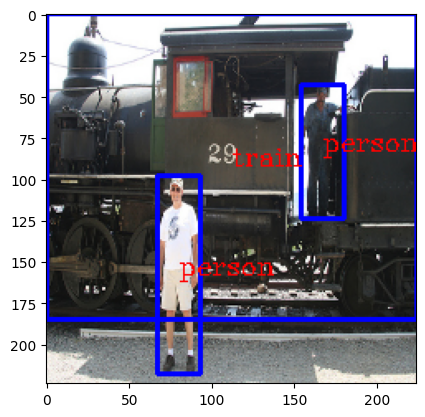

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from src import display
from src import data_transformer as dt
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP
from src.augmentations import RandomHorizontalFlip, RandomContrast

from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

IMG_PATH        = "./dataset/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./dataset/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path   = "./dataset/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

target_size = 224

seed = 42
device = "cuda"

data_list = []
id_cat, temp_list = dt.load_pascal(train_json_path)
data_list += temp_list
_, temp_list = dt.load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

data_list = dt.rescale_bounding_boxes(data_list, target_size)
data_list = dt.convert_to_center(data_list)

example = data_list[0]
example

img_str = IMG_PATH + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [7]:
anchor_grid    = [7, 4, 2, 1] # Number of grid-elements per dimension
anchor_zooms   = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios  = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales  = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes      = len(anchor_scales)

anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.to(device)

class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std  = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        if self.train_mode:
            img = self.contrast(img)
            img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std

        img = torch.from_numpy(img).float().to(device)

        #gt = gt / target_size
        gt = torch.from_numpy(gt).float() / self.target_size
        gt = gt[None, :, :].to(device)

        c = np.array(item.class_id) + 1
        c = torch.from_numpy(np.array(item.class_id)) + 1
        c = c[None, :].to(device)

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

batch_size = 128
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_dataset   = PascalData(data_list[split_idx:])
val_loader     = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, p, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class UpsampleModule(nn.Module):
    def __init__(self, in_channels, out_channels, p, scale_factor=2):
        super().__init__()
        self.conv = StandardConv(out_channels, out_channels, p, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")

    def forward(self, x, x_upsample):
        x = self.upsample(x_upsample) + x
        x = self.conv(x)
        return x

class FPN(nn.Module):
    def __init__(self, p):
        super().__init__()

        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-2]
        self.backbone = nn.Sequential(*pretrained_model)
        self.backbone_dropout = nn.Dropout2d(p=p[0])

        self.std_conv = nn.ModuleList([StandardConv(512, 256, p[1], stride=1),
                                       StandardConv(256, 256, p[1]),
                                       StandardConv(256, 256, p[1]),
                                       StandardConv(256, 256, p[1])
        ])

        self.upsample = nn.ModuleList([UpsampleModule(256, 256, p[1]),
                                       UpsampleModule(256, 256, p[1]),
                                       UpsampleModule(256, 256, p[1], scale_factor=7/4)

        ])

    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone_dropout(x)
        x = self.std_conv[0](x)

        x7 = x.clone()
        x4 = self.std_conv[1](x7)
        x2 = self.std_conv[2](x4)
        x1 = self.std_conv[3](x2)

        x_upsample_2 = self.upsample[0](x2, x1)
        x_upsample_4 = self.upsample[1](x4, x_upsample_2)
        x_upsample_7 = self.upsample[2](x7, x_upsample_4)

        return (x_upsample_7, x_upsample_4, x_upsample_2, x1)

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat) + 1) * self.num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4 * self.num_boxes, kernel_size=3, padding=1)

    def flatten_conv(self, x):
        samples, channels, _, _ = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        return x.view(samples, -1, int(channels / self.num_boxes))

    def forward(self, x):
        # [class predictions, box coordinates]
        return [self.flatten_conv(self.conv_1(x)),
                self.flatten_conv(self.conv_2(x))]

class RetinaNet(nn.Module):
    def __init__(self, num_boxes, p):
        super().__init__()
        self.fpn = FPN(p)
        self.fpn.change_freezing(False)

        self.out_conv = nn.ModuleList([
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes)
        ])

    def forward(self, x):
        fpn_out = self.fpn(x)

        output_class_7, output_bb_7 = self.out_conv[0](fpn_out[0])
        output_class_4, output_bb_4 = self.out_conv[1](fpn_out[1])
        output_class_2, output_bb_2 = self.out_conv[2](fpn_out[2])
        output_class_1, output_bb_1 = self.out_conv[3](fpn_out[3])

        return [torch.cat([output_class_7, output_class_4, output_class_2, output_class_1], dim=1),
                torch.cat([output_bb_7, output_bb_4, output_bb_2, output_bb_1], dim=1)
               ]

def find_overlap(bb_true_i, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)

    overlap_list = []
    for i in range(len(bb_true_i)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()

        if len(threshold_overlap) > 0:
            threshold_overlap = threshold_overlap[:, 0]
            overlap = torch.cat([max_overlap[i].view(1), threshold_overlap])
            overlap = torch.unique(overlap)
        else:
            overlap = max_overlap[i].view(1)
        overlap_list.append(overlap)
    return overlap_list

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

class Loss(nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_classes):
        # print(labels)
        # print(num_classes)
        labels_cpu = torch.tensor(labels, device = 'cpu')
        # print(labels_cpu)
        one_hot_results = torch.eye(num_classes)[labels_cpu]
        # print(one_hot_results)
        return one_hot_results


    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true):
        loc_loss = 0.0
        class_loss = 0.0

        for i in range(len(class_true)):  # Batch level
            class_hat_i = class_hat[i, :, :]
            bb_true_i = bb_true[i]
            class_true_i = class_true[i]
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(device)

            overlap_list = find_overlap(bb_true_i.squeeze(0), self.anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j]

                input_ = bb_hat[i, overlap, :]
                target_ = Loss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), self.anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = Loss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

loc_factor = 10.0
jaccard_overlap = 0.6

loss = Loss(loc_factor=loc_factor, anchors=anchors, jaccard_overlap=jaccard_overlap)

p = [0.2, 0.5]

model = RetinaNet(num_boxes=num_boxes, p=p).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 77.4MB/s]


In [8]:
n_epochs = 100
lr = 1e-3
wd = 1e-2

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

jaccard_threshold = 0.5
map_eval = MAP(model, val_dataset, jaccard_threshold, anchors)

torch.manual_seed(seed)
random.seed(seed)

torch.manual_seed(seed)
random.seed(seed)

from tqdm import tqdm, tqdm_notebook, trange

for epoch in range(n_epochs):
    model.train()

    train_loss, train_loc_loss, train_class_loss  = 0.0, 0.0, 0.0
    with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch+1}") as pbar:
        for _, (x, bb_true, class_true) in enumerate(train_loader):
            model.zero_grad()
            class_hat, bb_hat = model(x)

            batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)

            batch_loss.backward()
            optimizer.step()

            train_loss       += batch_loss.detach().to("cpu").numpy()
            train_class_loss += batch_class.detach().to("cpu").numpy()
            train_loc_loss   += batch_loc.detach().to("cpu").numpy()

            pbar.update(1)

        train_loss       =  np.round(train_loss / len(train_loader), 6)
        train_loc_loss   =  np.round(train_loc_loss / len(train_loader), 6)
        train_class_loss =  np.round(train_class_loss / len(train_loader), 6)

    val_loss, val_loc_loss, val_class_loss = 0.0, 0.0, 0.0
    with tqdm_notebook(total=len(val_loader), desc=f"Valid {epoch+1}") as pbar:
        for _, (x, bb_true, class_true) in enumerate(val_loader):
            class_hat, bb_hat = model(x)

            batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
            val_loss       += batch_loss.detach().to("cpu").numpy()
            val_loc_loss   += batch_loc.detach().to("cpu").numpy()
            val_class_loss += batch_class.detach().to("cpu").numpy()

            pbar.update(1)

        val_loss       = np.round(val_loss / len(val_loader), 6)
        val_loc_loss   = np.round(val_loc_loss / len(val_loader), 6)
        val_class_loss = np.round(val_class_loss / len(val_loader), 6)

    _, mAP = map_eval()
    mAP = np.round(mAP, 6)

    if (epoch+1) % 5 == 0:
        print(f"----- Epoch {epoch+1} -----")
        print(f"Train loss       : {train_loss}")
        print(f"Train loc loss   : {train_loc_loss}")
        print(f"Train class loss : {train_class_loss}")
        print(f"Val loss         : {val_loss}")
        print(f"Val loc loss     : {val_loc_loss}")
        print(f"Val class loss   : {val_class_loss}")
        print(f"Val mAP          : {mAP}")

<ipython-input-8-478068a05a0d>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch+1}") as pbar:


Train 1:   0%|          | 0/82 [00:00<?, ?it/s]

<ipython-input-7-1f9fa678b122>:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_cpu = torch.tensor(labels, device = 'cpu')
<ipython-input-8-478068a05a0d>:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(val_loader), desc=f"Valid {epoch+1}") as pbar:


Valid 1:   0%|          | 0/10 [00:00<?, ?it/s]

Train 2:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 2:   0%|          | 0/10 [00:00<?, ?it/s]

Train 3:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 3:   0%|          | 0/10 [00:00<?, ?it/s]

Train 4:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 4:   0%|          | 0/10 [00:00<?, ?it/s]

Train 5:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 5:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 5 -----
Train loss       : 6.196275
Train loc loss   : 0.19791
Train class loss : 4.217179
Val loss         : 6.584182
Val loc loss     : 0.217539
Val class loss   : 4.408794
Val mAP          : 0.217547


Train 6:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 6:   0%|          | 0/10 [00:00<?, ?it/s]

Train 7:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 7:   0%|          | 0/10 [00:00<?, ?it/s]

Train 8:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 8:   0%|          | 0/10 [00:00<?, ?it/s]

Train 9:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 9:   0%|          | 0/10 [00:00<?, ?it/s]

Train 10:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 10:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 10 -----
Train loss       : 5.57356
Train loc loss   : 0.178335
Train class loss : 3.790211
Val loss         : 6.165279
Val loc loss     : 0.222511
Val class loss   : 3.940169
Val mAP          : 0.299665


Train 11:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 11:   0%|          | 0/10 [00:00<?, ?it/s]

Train 12:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 12:   0%|          | 0/10 [00:00<?, ?it/s]

Train 13:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 13:   0%|          | 0/10 [00:00<?, ?it/s]

Train 14:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 14:   0%|          | 0/10 [00:00<?, ?it/s]

Train 15:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 15:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 15 -----
Train loss       : 5.178875
Train loc loss   : 0.163127
Train class loss : 3.547609
Val loss         : 5.429803
Val loc loss     : 0.184506
Val class loss   : 3.584745
Val mAP          : 0.347525


Train 16:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 16:   0%|          | 0/10 [00:00<?, ?it/s]

Train 17:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 17:   0%|          | 0/10 [00:00<?, ?it/s]

Train 18:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 18:   0%|          | 0/10 [00:00<?, ?it/s]

Train 19:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 19:   0%|          | 0/10 [00:00<?, ?it/s]

Train 20:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 20:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 20 -----
Train loss       : 4.8952
Train loc loss   : 0.15525
Train class loss : 3.342697
Val loss         : 5.368334
Val loc loss     : 0.159103
Val class loss   : 3.777308
Val mAP          : 0.379717


Train 21:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 21:   0%|          | 0/10 [00:00<?, ?it/s]

Train 22:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 22:   0%|          | 0/10 [00:00<?, ?it/s]

Train 23:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 23:   0%|          | 0/10 [00:00<?, ?it/s]

Train 24:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 24:   0%|          | 0/10 [00:00<?, ?it/s]

Train 25:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 25:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 25 -----
Train loss       : 4.70423
Train loc loss   : 0.146139
Train class loss : 3.242841
Val loss         : 5.470114
Val loc loss     : 0.193596
Val class loss   : 3.534158
Val mAP          : 0.406952


Train 26:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 26:   0%|          | 0/10 [00:00<?, ?it/s]

Train 27:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 27:   0%|          | 0/10 [00:00<?, ?it/s]

Train 28:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 28:   0%|          | 0/10 [00:00<?, ?it/s]

Train 29:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 29:   0%|          | 0/10 [00:00<?, ?it/s]

Train 30:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 30:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 30 -----
Train loss       : 4.573612
Train loc loss   : 0.142407
Train class loss : 3.149543
Val loss         : 5.082183
Val loc loss     : 0.172491
Val class loss   : 3.357273
Val mAP          : 0.425191


Train 31:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 31:   0%|          | 0/10 [00:00<?, ?it/s]

Train 32:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 32:   0%|          | 0/10 [00:00<?, ?it/s]

Train 33:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 33:   0%|          | 0/10 [00:00<?, ?it/s]

Train 34:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 34:   0%|          | 0/10 [00:00<?, ?it/s]

Train 35:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 35:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 35 -----
Train loss       : 4.450737
Train loc loss   : 0.137281
Train class loss : 3.077923
Val loss         : 5.348259
Val loc loss     : 0.198132
Val class loss   : 3.366939
Val mAP          : 0.441164


Train 36:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 36:   0%|          | 0/10 [00:00<?, ?it/s]

Train 37:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 37:   0%|          | 0/10 [00:00<?, ?it/s]

Train 38:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 38:   0%|          | 0/10 [00:00<?, ?it/s]

Train 39:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 39:   0%|          | 0/10 [00:00<?, ?it/s]

Train 40:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 40:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 40 -----
Train loss       : 4.324651
Train loc loss   : 0.130225
Train class loss : 3.022396
Val loss         : 5.083981
Val loc loss     : 0.162525
Val class loss   : 3.45873
Val mAP          : 0.450399


Train 41:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 41:   0%|          | 0/10 [00:00<?, ?it/s]

Train 42:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 42:   0%|          | 0/10 [00:00<?, ?it/s]

Train 43:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 43:   0%|          | 0/10 [00:00<?, ?it/s]

Train 44:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 44:   0%|          | 0/10 [00:00<?, ?it/s]

Train 45:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 45:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 45 -----
Train loss       : 4.179129
Train loc loss   : 0.123838
Train class loss : 2.940747
Val loss         : 5.259765
Val loc loss     : 0.181725
Val class loss   : 3.44252
Val mAP          : 0.476025


Train 46:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 46:   0%|          | 0/10 [00:00<?, ?it/s]

Train 47:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 47:   0%|          | 0/10 [00:00<?, ?it/s]

Train 48:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 48:   0%|          | 0/10 [00:00<?, ?it/s]

Train 49:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 49:   0%|          | 0/10 [00:00<?, ?it/s]

Train 50:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 50:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 50 -----
Train loss       : 4.092256
Train loc loss   : 0.119926
Train class loss : 2.893
Val loss         : 5.313547
Val loc loss     : 0.1491
Val class loss   : 3.822552
Val mAP          : 0.475228


Train 51:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 51:   0%|          | 0/10 [00:00<?, ?it/s]

Train 52:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 52:   0%|          | 0/10 [00:00<?, ?it/s]

Train 53:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 53:   0%|          | 0/10 [00:00<?, ?it/s]

Train 54:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 54:   0%|          | 0/10 [00:00<?, ?it/s]

Train 55:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 55:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 55 -----
Train loss       : 4.006675
Train loc loss   : 0.118
Train class loss : 2.826673
Val loss         : 4.786644
Val loc loss     : 0.142361
Val class loss   : 3.363031
Val mAP          : 0.49395


Train 56:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 56:   0%|          | 0/10 [00:00<?, ?it/s]

Train 57:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 57:   0%|          | 0/10 [00:00<?, ?it/s]

Train 58:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 58:   0%|          | 0/10 [00:00<?, ?it/s]

Train 59:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 59:   0%|          | 0/10 [00:00<?, ?it/s]

Train 60:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 60:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 60 -----
Train loss       : 3.923633
Train loc loss   : 0.112963
Train class loss : 2.794003
Val loss         : 5.409704
Val loc loss     : 0.177982
Val class loss   : 3.629888
Val mAP          : 0.494588


Train 61:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 61:   0%|          | 0/10 [00:00<?, ?it/s]

Train 62:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 62:   0%|          | 0/10 [00:00<?, ?it/s]

Train 63:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 63:   0%|          | 0/10 [00:00<?, ?it/s]

Train 64:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 64:   0%|          | 0/10 [00:00<?, ?it/s]

Train 65:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 65:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 65 -----
Train loss       : 3.864167
Train loc loss   : 0.111408
Train class loss : 2.750087
Val loss         : 4.385226
Val loc loss     : 0.13598
Val class loss   : 3.025421
Val mAP          : 0.502081


Train 66:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 66:   0%|          | 0/10 [00:00<?, ?it/s]

Train 67:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 67:   0%|          | 0/10 [00:00<?, ?it/s]

Train 68:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 68:   0%|          | 0/10 [00:00<?, ?it/s]

Train 69:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 69:   0%|          | 0/10 [00:00<?, ?it/s]

Train 70:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 70:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 70 -----
Train loss       : 3.850757
Train loc loss   : 0.111361
Train class loss : 2.737144
Val loss         : 4.694916
Val loc loss     : 0.152406
Val class loss   : 3.170852
Val mAP          : 0.498219


Train 71:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 71:   0%|          | 0/10 [00:00<?, ?it/s]

Train 72:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 72:   0%|          | 0/10 [00:00<?, ?it/s]

Train 73:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 73:   0%|          | 0/10 [00:00<?, ?it/s]

Train 74:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 74:   0%|          | 0/10 [00:00<?, ?it/s]

Train 75:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 75:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 75 -----
Train loss       : 3.733972
Train loc loss   : 0.105918
Train class loss : 2.674787
Val loss         : 6.035657
Val loc loss     : 0.148537
Val class loss   : 4.550288
Val mAP          : 0.506331


Train 76:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 76:   0%|          | 0/10 [00:00<?, ?it/s]

Train 77:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 77:   0%|          | 0/10 [00:00<?, ?it/s]

Train 78:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 78:   0%|          | 0/10 [00:00<?, ?it/s]

Train 79:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 79:   0%|          | 0/10 [00:00<?, ?it/s]

Train 80:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 80:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 80 -----
Train loss       : 3.667742
Train loc loss   : 0.10476
Train class loss : 2.620137
Val loss         : 4.940681
Val loc loss     : 0.16512
Val class loss   : 3.289478
Val mAP          : 0.515904


Train 81:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 81:   0%|          | 0/10 [00:00<?, ?it/s]

Train 82:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 82:   0%|          | 0/10 [00:00<?, ?it/s]

Train 83:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 83:   0%|          | 0/10 [00:00<?, ?it/s]

Train 84:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 84:   0%|          | 0/10 [00:00<?, ?it/s]

Train 85:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 85:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 85 -----
Train loss       : 3.614437
Train loc loss   : 0.101841
Train class loss : 2.596027
Val loss         : 4.504495
Val loc loss     : 0.141068
Val class loss   : 3.093818
Val mAP          : 0.514832


Train 86:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 86:   0%|          | 0/10 [00:00<?, ?it/s]

Train 87:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 87:   0%|          | 0/10 [00:00<?, ?it/s]

Train 88:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 88:   0%|          | 0/10 [00:00<?, ?it/s]

Train 89:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 89:   0%|          | 0/10 [00:00<?, ?it/s]

Train 90:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 90:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 90 -----
Train loss       : 3.572448
Train loc loss   : 0.100301
Train class loss : 2.569442
Val loss         : 4.601489
Val loc loss     : 0.149519
Val class loss   : 3.106301
Val mAP          : 0.518843


Train 91:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 91:   0%|          | 0/10 [00:00<?, ?it/s]

Train 92:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 92:   0%|          | 0/10 [00:00<?, ?it/s]

Train 93:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 93:   0%|          | 0/10 [00:00<?, ?it/s]

Train 94:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 94:   0%|          | 0/10 [00:00<?, ?it/s]

Train 95:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 95:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 95 -----
Train loss       : 3.505118
Train loc loss   : 0.097786
Train class loss : 2.527254
Val loss         : 4.575895
Val loc loss     : 0.140389
Val class loss   : 3.172
Val mAP          : 0.519493


Train 96:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 96:   0%|          | 0/10 [00:00<?, ?it/s]

Train 97:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 97:   0%|          | 0/10 [00:00<?, ?it/s]

Train 98:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 98:   0%|          | 0/10 [00:00<?, ?it/s]

Train 99:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 99:   0%|          | 0/10 [00:00<?, ?it/s]

Train 100:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 100:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 100 -----
Train loss       : 3.448092
Train loc loss   : 0.095809
Train class loss : 2.490006
Val loss         : 4.836368
Val loc loss     : 0.158609
Val class loss   : 3.250283
Val mAP          : 0.5291


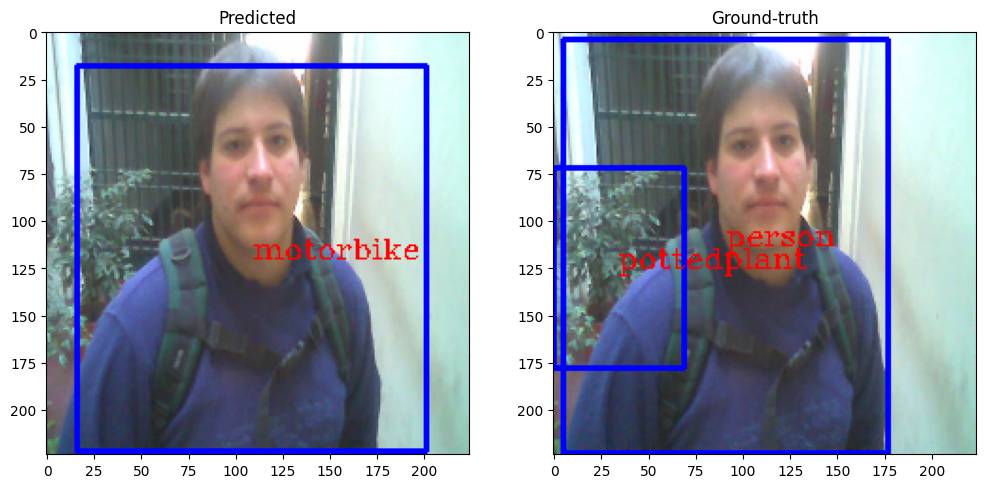

In [9]:
background_threshold = 0.5

i = 1
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename

model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = dt.invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)

# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]

if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []

output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0],
                                           bb_hat[j, 1],
                                           bb_hat[j, 2],
                                           bb_hat[j, 3]])
             for j in range(len(prob))]

output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)

filtered_bb = non_max_suppression(output_bb)

example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file
f, axs = plt.subplots(1, 2, figsize=(12, 12))

img_pred = display.read_img(img_str, target_size)
img_pred = display.draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = display.draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = display.read_img(img_str, target_size)
img_gt = display.draw_boxes(img_gt, example.bounding_boxes)
img_gt = display.draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()